# 날코딩으로 이미지 데이터 불러오기
수업 내용은 아니지만 꽂혀서 만들어봄...

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [331]:
class DataGenerator:
    def __init__(self, path, batch=32, target_size=(224,224)):
        self.path = path
        self.batch = batch
        self.target_size = target_size
        self.classes = [_ for _ in os.listdir(data_dir) if "." not in _]
        self.class_indices = {i:cls for i, cls in enumerate(self.classes)}
        self.class_files = {cls:[os.path.join(path, cls, file) for file in os.listdir(os.path.join(path, cls))] 
                            for cls in self.classes}
        self.index_classes = {v:k for k,v in self.class_indices.items()}
        
    @classmethod
    def load_image(cls, path, target_size=(224,224)):
        return np.array(Image.open(path).resize(target_size))    
    
    @classmethod
    def data_gen(cls, path, batch=32, target_size=(224,224)):
        return DataGenerator(path, batch, target_size)

    def __iter__(self):
        self.data = []
        for cls, files in self.class_files.items():
            for file in files:
                self.data.append((self.index_classes[cls], file))
        
        shuffle(self.data)
        
        self.start, self.end = 0, self.batch
        self.length = len(self.data)
        return self
        
    def __next__(self):
        if self.start > self.length:
            raise StopIteration
        
        temp = []
        y = []
        for cls, file in self.data[self.start:self.end]:
            temp.append(DataGenerator.load_image(file, self.target_size)) # 이미지 읽어오기 
            y.append(cls) # 정답 데이터
        self.start, self.end = self.end, self.end+self.batch
        return np.stack(temp, axis=0), y

In [332]:
test = DataGenerator.data_gen(data_dir)

In [339]:
test.class_indices

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [333]:
iter(test)

In [334]:
x, y = next(test)

In [335]:
x.shape

(32, 224, 224, 3)

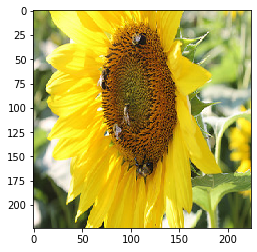

In [338]:
plt.imshow(x[0])
plt.show()

In [337]:
y

[3,
 4,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 3,
 3,
 1,
 3,
 2,
 2,
 4,
 1,
 2,
 1,
 0,
 2,
 4,
 1,
 4,
 2,
 1,
 2,
 4,
 0,
 4,
 2]

In [323]:
while 1:
    next(test)

StopIteration: 

---

# 데이터 불러오기
가장 기본이다. 실제로 면접에서 데이터 못 불러오는 사람이 80%이다.

튜토리얼을 기반으로 수업함
https://www.tensorflow.org/tutorials/load_data/images

In [34]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [30]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [31]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [32]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

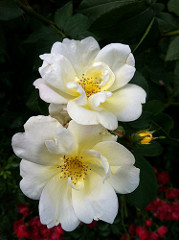

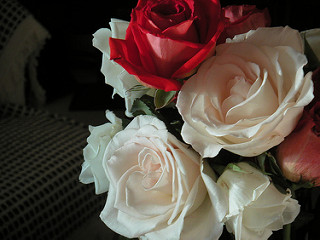

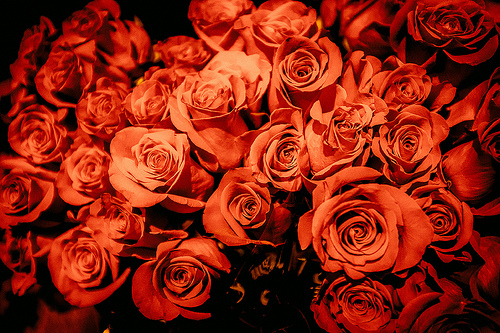

In [35]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [24]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [36]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [37]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [367]:
"next" in dir(train_data_gen) # next가 있는 걸 보면 iterator/generator이다.

True

In [42]:
train_data_gen.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

> 클래스별 라벨 번호를 알 수 있다.


[0. 0. 0. 0. 1.]


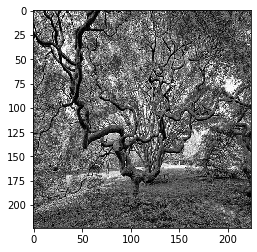

In [366]:
x, y = next(train_data_gen)
print(y[0])
plt.imshow(x[0])
plt.show()

> - 정답은 One hot encoding 되어 있다.
- 이미지가 배치 형태로 되어 있다.

In [38]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

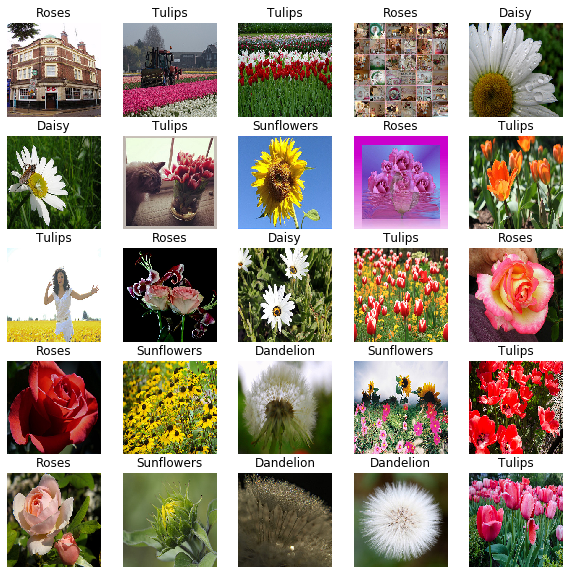

In [39]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

---

# Transfer Learning 실습
## 모델 불러오기(base모델: vgg16)

In [346]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

> - `include_top=False`: classifier를 제외하고 모델을 불러옴
- `weights="imagenet`: pre-trained 모델의 학습데이터 선택
- `input_shape=(224,224,3)`: classifier 없이 convolution layer로만 구성되어 있는 경우, input_shape이 중요하지 않다. 왜냐하면 convolution layer는 input 크기에 상관없이 계산할 수 있기 때문이다.

In [347]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [348]:
# Error!

base_model.add(tf.keras.layers.Dense(5, activation="softmax"))

AttributeError: 'Model' object has no attribute 'add'

> - vgg 모델에는 add가 없다. 
- add는 Sequential로 모델을 만들었을 때만 있음.

In [349]:
[_ for _ in dir(base_model) if not _.startswith("_")] # add가 없다.

['activity_regularizer',
 'add_loss',
 'add_metric',
 'add_update',
 'add_variable',
 'add_weight',
 'apply',
 'build',
 'built',
 'call',
 'compile',
 'compute_mask',
 'compute_output_shape',
 'compute_output_signature',
 'count_params',
 'dtype',
 'dynamic',
 'evaluate',
 'evaluate_generator',
 'fit',
 'fit_generator',
 'from_config',
 'get_config',
 'get_input_at',
 'get_input_mask_at',
 'get_input_shape_at',
 'get_layer',
 'get_losses_for',
 'get_output_at',
 'get_output_mask_at',
 'get_output_shape_at',
 'get_updates_for',
 'get_weights',
 'inbound_nodes',
 'input',
 'input_mask',
 'input_names',
 'input_shape',
 'input_spec',
 'inputs',
 'layers',
 'load_weights',
 'losses',
 'metrics',
 'metrics_names',
 'name',
 'name_scope',
 'non_trainable_variables',
 'non_trainable_weights',
 'optimizer',
 'outbound_nodes',
 'output',
 'output_mask',
 'output_names',
 'output_shape',
 'outputs',
 'predict',
 'predict_generator',
 'predict_on_batch',
 'reset_metrics',
 'reset_states',
 'run_

## 튜토리얼에 없는 방법
- model의 layer를 list로 가져와서 layer를 append해서 만드는 방법
- sequential을 이용함

In [350]:
# layer freeze

temp = []
for layer in base_model.layers:
    layer.trainable = False
    temp.append(layer)
temp

In [351]:
temp.append(tf.keras.layers.Flatten())
temp.append(tf.keras.layers.Dense(32, activation="relu"))
temp.append(tf.keras.layers.Dense(5, activation="softmax"))

In [352]:
model = tf.keras.Sequential(temp)

In [353]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        multiple                  73856     
_________________________________________________________________
block2_conv2 (Conv2D)        multiple                  147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                 

In [355]:
model.compile(loss="sparse_categorical_crossentropy",
               optimizer="adam",
               metrics=["acc"])

In [ ]:
history = model.fit_generator(train_data_gen)

# 케라스 함수형 API

In [356]:
# 함수형 방법

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(5, activation="relu")(x)
prediction = tf.keras.layers.Dense(5, activation="softmax")(x)

model2 = tf.keras.Model(inputs=model.input, 
                        outputs=prediction)

In [358]:
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [374]:
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [ ]:
# 시간상 학습은 생략
history2 = model2.fit_generator(train_data_gen)

---

# input_shape을 기억하자

In [359]:
# input_shape을 안 쓰면 output_shape이 (None, None, None, n) 이 된다.
from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     